In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import silhouette_score

from preprocessing import load_data, creer_features_date, creer_feature_ligne, frequency_encoding, drop_pourcentages_incorrects
from clustering import preprocess_clustering, recherche_meilleur_clustering_par_lignes

## Importation des données

In [2]:
data = load_data()
creer_features_date(data)

drop_pourcentages_incorrects(data)

train_data = data[data['annee'] < 2023]
test_data = data[data['annee'] == 2023]
X_train, y_train, X_test, y_test = frequency_encoding(train_data, test_data)

c:\Users\User\Desktop\apprauto\sncf_td1_gr1\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['gare_depart_encoded'] = train_data['gare_depart'].map(frequency_encoding)
c:\Users\User\Desktop\apprauto\sncf_td1_gr1\preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(frequency_encoding)
c:\Users\User\Desktop\apprauto\sncf_td1_gr1\preprocessing.py:25: SettingWithCopyWarning: 
A value is trying to be se

## I. Clustering des lignes de train sur les causes de retard

In [3]:
features_cause = [col for col in data.columns if col.startswith('prct')]
creer_feature_ligne(data)

clustering_data = preprocess_clustering(data, echelle='ligne')

Calcul des inerties: 100%|██████████| 39/39 [00:12<00:00,  3.23it/s]


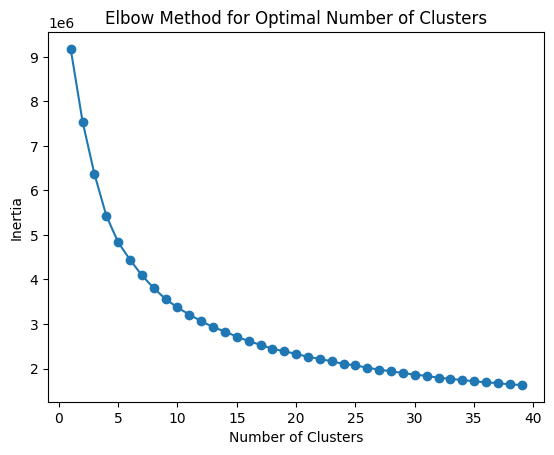

Calcul des Silhouette scores: 100%|██████████| 38/38 [00:49<00:00,  1.30s/it]


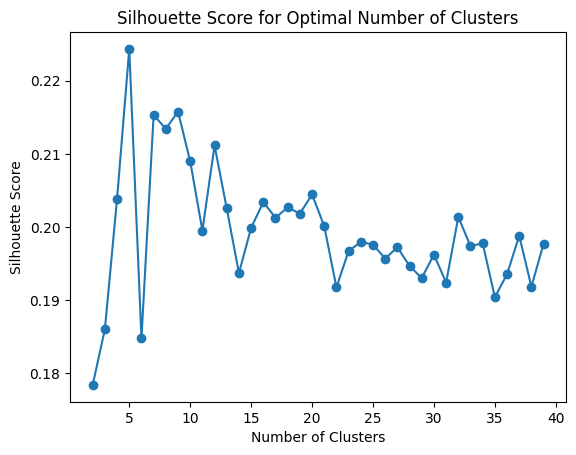

In [4]:
recherche_meilleur_clustering_par_lignes(data)

Considérer 18 cluster semble être un choix pertinent

In [5]:
# Fit k-means on 18 clusters
kmeans = KMeans(n_clusters=18)
cluster_labels = kmeans.fit_predict(clustering_data[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']])
clustering_data['cluster'] = cluster_labels

barycentres = clustering_data.groupby('cluster')[features_cause].mean().reset_index()

# Dans le dataset de test, on ajoute les pourcentage de causes obtenues via clustering
for col in features_cause:
    test_data[col]=None

for i in range(len(test_data)):
    instance=test_data.iloc[i]
    cluster_ligne=int(clustering_data["cluster"][clustering_data['ligne']==instance["ligne"]])
    for col in features_cause:
        test_data.at[i, col]=barycentres[col][barycentres.cluster==cluster_ligne]

barycentres = clustering_data.groupby('cluster')[features_cause].mean().reset_index()

# Dans le dataset de test, on ajoute les pourcentage de causes obtenues via clustering
for col in features_cause:
    test_data[col]=None

for i in range(len(test_data)):
    instance=test_data.iloc[i]
    cluster_ligne=int(clustering_data["cluster"][clustering_data.ligne==instance["ligne"]])
    for col in features_cause:
        test_data.at[i, col]=barycentres[col][barycentres.cluster==cluster_ligne]

C:\Users\User\AppData\Local\Temp\ipykernel_33112\219140560.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col]=None


KeyError: 'ligne'

In [ ]:
X_train, y_train, X_test, y_test = frequency_encoding(train_data, test_data)

c:\Users\User\Desktop\apprauto\sncf_td1_gr1\preprocessing.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['gare_depart_encoded'] = train_data['gare_depart'].map(frequency_encoding)
c:\Users\User\Desktop\apprauto\sncf_td1_gr1\preprocessing.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['gare_arrivee_encoded'] = train_data['gare_arrivee'].map(frequency_encoding)
c:\Users\User\Desktop\apprauto\sncf_td1_gr1\preprocessing.py:25: SettingWithCopyWarning: 
A value is trying to be se

## II. Clustering pour encodage des gares de départ et d'arrivée

### Gare de départ

In [ ]:
data_clustering_depart = data[data['annee'] < 2023]
data_clustering_depart = data_clustering_depart.groupby('gare_depart').agg({'duree_moyenne': 'mean',
                                         'retard_moyen_arrivee': 'mean',
                                         'nb_train_prevu': 'mean',
                                         'nb_train_depart_retard': 'mean',
                                         'retard_moyen_depart': 'mean',
                                         'retard_moyen_tous_trains_depart' :'mean'}).reset_index()

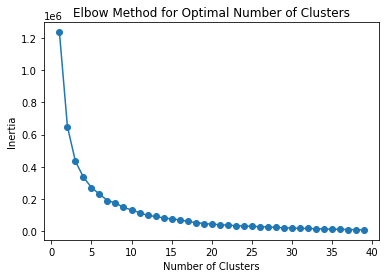

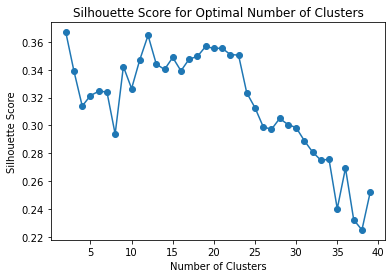

In [ ]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 40)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 40)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']])
    silhouette_avg = silhouette_score(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

On prend donc 12 clusters

In [ ]:
# Fit k-means on 12 clusters
kmeans = KMeans(n_clusters=12, random_state=0)
cluster_labels = kmeans.fit_predict(data_clustering_depart[["duree_moyenne",'nb_train_prevu', 'nb_train_depart_retard', 'retard_moyen_depart', 'retard_moyen_tous_trains_depart']])
data_clustering_depart['cluster'] = cluster_labels

### Gare d'arrivée

In [ ]:
data_clustering_arrivee = data[data['annee'] < 2023]

data_clustering_arrivee = data_clustering_arrivee.groupby('gare_arrivee').agg({'duree_moyenne': 'mean',
                                         'nb_train_prevu': 'mean',
                                         'nb_train_retard_arrivee' :'mean',
                                         'retard_moyen_depart' : 'mean',
                                         'retard_moyen_tous_trains_depart': 'mean',
                                         'nb_train_retard_arrivee': 'mean',
                                         'retard_moyen_arrivee': 'mean',
                                         'retard_moyen_tous_trains_arrivee' : 'mean'}).reset_index()

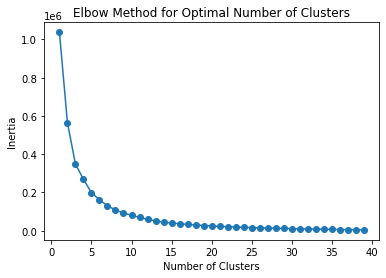

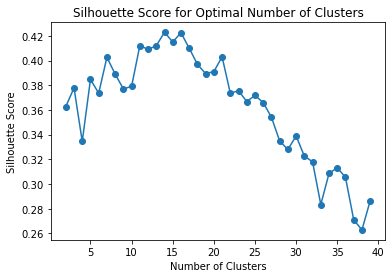

In [ ]:
inertia = []

# Define a range of cluster numbers to test
cluster_range = range(1, 40)

# Calculate inertia for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']])
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Create an empty list to store silhouette scores
silhouette_scores = []

# Define a range of cluster numbers to test
cluster_range = range(2, 40)  # Start with a minimum of 2 clusters

# Calculate silhouette scores for each cluster number
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    cluster_labels = kmeans.fit_predict(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']])
    silhouette_avg = silhouette_score(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Score graph
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.show()

On prend donc 14 clusters

In [ ]:
# Fit k-means on 14 clusters
kmeans = KMeans(n_clusters=14)
cluster_labels = kmeans.fit_predict(data_clustering_arrivee[["duree_moyenne",'nb_train_prevu', 'nb_train_retard_arrivee','retard_moyen_depart', 'retard_moyen_tous_trains_depart', 'nb_train_retard_arrivee', 'retard_moyen_arrivee', 'retard_moyen_tous_trains_arrivee']])
data_clustering_arrivee['cluster'] = cluster_labels

### Encodage des gares

In [ ]:
data['gare_depart_encoded'] = data['gare_depart'].map(data_clustering_depart.set_index('gare_depart')['cluster'])
data['gare_arrivee_encoded'] = data['gare_arrivee'].map(data_clustering_arrivee.set_index('gare_arrivee')['cluster'])

# Séparer les données d'entraînement et de test
train_data = data[data['annee'] < 2023]
test_data = data[data['annee'] == 2023]

test_data=test_data.reset_index()

# Dans le dataset de test, on ajoute les pourcentage de causes obtenues via clustering
for col in features_cause:
    test_data[col]=None

for i in range(len(test_data)):
    instance=test_data.iloc[i]
    cluster_ligne=int(clustering_data["cluster"][clustering_data.ligne==instance["ligne"]])
    for col in features_cause:
        test_data.at[i, col]=barycentres[col][barycentres.cluster==cluster_ligne]

# Colonnes d'entrée
features = ['annee', 'mois', 'gare_depart_encoded', 'gare_arrivee_encoded', 'nb_train_prevu','duree_moyenne']
features_avec_causes=features+features_cause
# Colonnes cible
target = 'retard_moyen_arrivee'

X_train_data=train_data[features_avec_causes]
y_train_data=train_data[target]

X_test_data=test_data[features_avec_causes]
y_test=test_data[target]



# 3. Selection du meilleur modèle et résultat

In [ ]:
N=100
mae_tab=np.zeros(N)
estimators=range(1,N+1)

for i in estimators:

    random_forest_model = RandomForestRegressor(n_estimators=i,max_features= 0.4, max_samples= 0.1)
    random_forest_model.fit(X_train, y_train)

    # Prédiction sur l'ensemble de test
    y_pred = random_forest_model.predict(X_test)

    # Évaluer la performance du modèle (par exemple, RMSE)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    mae_tab[i-1]=mae

plt.plot(estimators, mae_tab)
plt.title("MAE en fontion du nombre d'estimateurs")
plt.show()

print(f'RMSE: {rmse} ')
print(f'MAE: {mae} ')

NameError: name 'X_train_data' is not defined

In [ ]:
pgrid = {"max_samples": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
      "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

grid_search=RandomizedSearchCV(RandomForestRegressor(n_estimators=100), param_distributions=pgrid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = grid_search.best_estimator_.predict(X_test)

# Évaluer la performance du modèle (par exemple, RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f'Best model RMSE: {rmse} ')
print(f'Best model MAE: {mae} ')

print(f'Best model params: {grid_search.best_params_} ')


Best model RMSE: 17.079483214656634 
Best model MAE: 9.044809429007861 
Best model params: {'max_samples': 0.2, 'max_features': 0.2} 


In [ ]:
# Récupérer l'importance des features
feature_importances =random_forest_model.feature_importances_
feature_names = X_train_data.columns

# Créer un DataFrame pour une visualisation plus facile
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Trier les features par importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Tracer l'importance des features
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importance des Features dans le modèle Random Forest')
plt.show()